Ahmad Moussa

ID: 5119FG10

Graphics Optimization assignment 1

Mean squared error:  1.0499999999999998


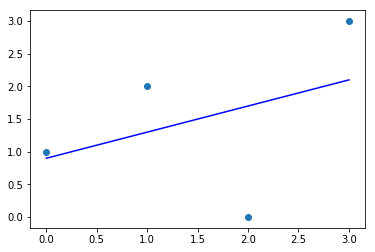

In [41]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

A = np.array(((0,1),
             (1,1),
             (2,1),
             (3,1)))

b = np.array((1,2,0,3), ndmin = 2 ).T

xstar = np.matmul( np.matmul( np.linalg.inv( np.matmul(A.T, A) ), A.T), b)

plt.scatter(A.T[0], b)
u = np.linspace(0,3,100)
plt.plot(u, u * xstar[0] + xstar[1], 'b-')

error = []
for i in range(len(b)):
    y_pred = A.T[0][i] * xstar[0] + xstar[1]
    error.append(np.square(y_pred - b[i]))

print("Mean squared error: ", np.sum(error)/len(b))

### 1. Compute the hessian and make sure it is semi-definite positive:

Since our function is of the form: 

\begin{align} f(x) = \frac{1}{2} ||Ax + b||^2\end{align} 

And the hessian matrix is the matrix of second order partial-derivatives. We can rewrite our function such that we can make use of the chain rule:

\begin{align} f(x) = g(h(x))\end{align} where \begin{align}h(x) = Ax - b \end{align} and \begin{align} g(y) = \frac{1}{2} ||y||^2\end{align}. 

The partial derivatives are given by:

\begin{align} g'(y) = y^T, h'(x) = A \end{align}

Now using the chain rule, we have that:

\begin{align} f'(x) = g'(h(x))h'(x) = (Ax - b)^TA \end{align}

The gradient is a column vector, therefore:

\begin{align} ∇f(x) = f′(x)^T = A^T(Ax−b) \end{align}

Then finally, the hessian is the derivative of the previous:

\begin{align} Hf(x) = A^TA \end{align}

And now we can easily compute this in python.[This](https://math.stackexchange.com/questions/809169/hessian-matrix-as-derivative-of-gradient) helped me understand the calculation, and [this](https://math.stackexchange.com/questions/2864585/hessian-on-linear-least-squares-problem) provided several different ways to derive the hessian matrix from a least squares problem. Now we still need to make sure that the hessian is semi-positive definite. Let's do that step in python:

In [122]:
import numpy as np

A = np.array(((0,1),
             (1,1),
             (2,1),
             (3,1)))
Hessian = np.matmul(A.T, A) 
print("Hessian: ")
print(Hessian)
# Allclose checks if two arrays are elementwise equal
# A matrice is symmetric if it is equal to it's transpose
print("Is the Hessian symmetric: ", np.allclose(Hessian, Hessian.T))
print("Eigenvalues: ", np.linalg.eigvals(Hessian))
print("Are the eigenvalues positive: ", np.linalg.eigvals(Hessian) > 0)


Hessian: 
[[14  6]
 [ 6  4]]
Is the Hessian symmetric:  True
Eigenvalues:  [16.81024968  1.18975032]
Are the eigenvalues positive:  [ True  True]


#### Figuring out curve fitting:

Prior to this assignment I have never done any line or curve fitting. Hence I had no idea what to expect. Obviously, the point of the assignment was to avoid using numpy's polyfit function that does a perfectly good job at fitting polynomials of any order to a certain number of data points. I used the polyfit function as a cross-reference and as a measure of accuracy for my own code though.

### 2. How would you fit the quadratic model:  \begin{align} α_0 u^2 + α_1 u + β \end{align}

I assumed that I had to fit this quadratic function using a different method than the least squares method. I found that it could be fit using cramer's rule ([according to this article](https://neutrium.net/mathematics/least-squares-fitting-of-a-polynomial/)), by finding the determinants with respect to every column in our feature matrix and using these as coefficients for our curve.

But there is one little problem, I discovered that this only works if the number of points to be fit is equal to the order of our polynomial + 1. We're trying to fit a quadratic model to 4 points, and obviously, 3 is not 4. I had some help debugging this using stackoverflow, as they pointed out that it would not work with the number of points that I have, here is a [link to my question](https://stackoverflow.com/questions/56181712/fitting-a-quadratic-function-in-python-without-numpy-polyfit)

Hence to not throw this method out of the window completely, I tried replacing two of our points with one that lies between our points, and fit a curve to it with my code. The results can be seen in the graph below, where the blue line is my cramer fit, and the red dashed line is numpy's polyfit curve. We're actually not that far off, but I think there is abetter way to solve this.

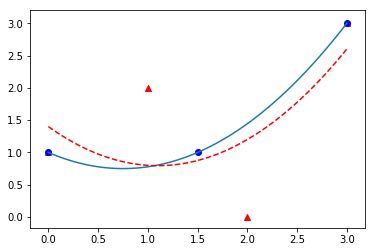

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# Our points 
A = np.array(((0,1),
             (1,1),
             (2,1),
             (3,1)))
A2 = np.array(((0,1),
             (1.5,1),
             (3,1)))
xfeature = A2.T[0]
squaredfeature = A2.T[0] ** 2
ones = np.ones(3)
# Let's create the matrix
features = np.concatenate((np.vstack(ones), np.vstack(xfeature), np.vstack(squaredfeature)), axis = 1)


b = np.array((1,2,0,3), ndmin=2 ).T
b2 = np.array((1,1,3), ndmin=2 ).T
b2 = b2.reshape(3)

# Order of the polynomial we want to fit
order = 2

# Copy the matrix to do some operations with it
featuresc = features.copy()

# Let's find the determinants with respect to each of our columns
m_det = np.linalg.det(features)
determinants = []
for i in range(order + 1):
    featuresc.T[i] = b2 
    determinants.append(np.linalg.det(featuresc))
    featuresc = features.copy()

determinants = determinants / m_det

# Plotting it
plt.scatter(A.T[0],b, c = 'red', marker = '^')
plt.scatter(A2.T[0],b2, c = 'blue')
u = np.linspace(0,3,100)
plt.plot(u, u**2*determinants[2] + u*determinants[1] + determinants[0] )
p2 = np.polyfit(A.T[0],b,2)
plt.plot(u, np.polyval(p2,u), 'r--')
plt.show()

#### Let's go back to using the least squares method:

It turned out to be a little easier than I thought. [In my stackoverflow question](https://stackoverflow.com/questions/56181712/fitting-a-quadratic-function-in-python-without-numpy-polyfit), I was told that it can be solved using least squares, as oppsed to my assumption. It simply boils down to adding a quadratic term to the feature matrix and solve it analytically, using the same equation that was provided in the example:

 \begin{align} (X^T X)^{-1} X^Ty\end{align}
 
 And this worked very well, as it gives the same output as numpy's polyfit function. See below, the blue dotted curve is my fit, and in dashed red the polyfit curve.

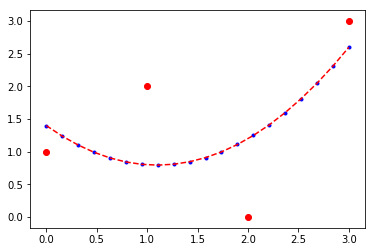

Mean squared error: 0.8


In [43]:
# Therefore, we need a better way to fit our quadratic function
# that works for more than three points
import numpy as np
import matplotlib.pyplot as plt

# Our points 
A = np.array(((0,1),
             (1,1),
             (2,1),
             (3,1)))
xfeature = A.T[0]
squaredfeature = A.T[0] ** 2
#squaredfeature = A.T[1]
ones = np.ones(4)

b = np.array((1,2,0,3), ndmin=2 ).T
b = b.reshape(4)


#Order of our polynomial
order = 2

# Let's create the matrix
features = np.concatenate((np.vstack(ones), np.vstack(xfeature), np.vstack(squaredfeature)), axis = 1)
xstar = np.matmul( np.matmul( np.linalg.inv( np.matmul(features.T, features) ), features.T), b)

plt.scatter(A.T[0],b, c = 'red')
u = np.linspace(0,3,20)
plt.plot(u, u**2*xstar[2] + u*xstar[1] + xstar[0], 'b.')
p2 = np.polyfit(A.T[0],b,2)
plt.plot(u, np.polyval(p2,u), 'r--')
plt.show()


error = []
for i in range(len(b)):
    y_pred = (A.T[0][i]**2) * xstar[2] + A.T[0][i] * xstar[1] + xstar[0]
    error.append(np.square(y_pred - b[i]))

print("Mean squared error:",np.sum(error)/len(b))

#### Different method:
Well, I still didn't feel satisfied because I wanted to solve it in a different way. I wanted to try using gradient descent, as I have never actually implemented it myself. I also had some trouble implementing it, and this [stackoverflow question](https://stackoverflow.com/questions/56205574/fitting-a-line-with-gradient-descent) I opened, summarizes what went wrong and how I solved it, I mainly had problems calculating the derivatives.See in the graph below, we get a line similar to our initial example:

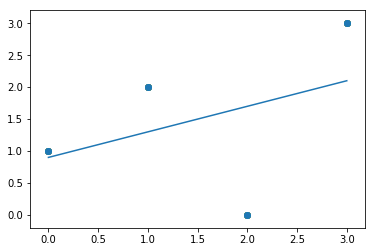

In [109]:
# We could also solve it using gradient descent
# This is gradient descent fits a line to our data using the partial derivatives
import numpy as np
import matplotlib.pyplot as plt

# Our loss function is going to be the mean squared error
def mean_squared_error(n, A, b, alpha,beta):
    e = 0
    for i in range(n):
        e += ((b[i] - (alpha * A[i] + beta** 2)))   
    #print("mse:",e/n)
    return e/n

# derivative with respect to alpha
def der_wrt_alpha(n,A,b,alpha,beta):
    d = 0
    for i in range(n):
        # d += (2 * (b[i] - (m*A[i] + c)) * (-A[i]))
        d += (A[i] * (b[i] - (alpha*A[i] + beta)))
    #print("D_alpha",-2 * d/n)
    return (-2 * d/n)
  
#derivative with respect to beta
def der_wrt_beta(n,A,b,alpha,beta):
    d = 0
    for i in range(n):
        d += (2 * (-1) * (b[i] - (alpha*A[i] + beta)))
    #print("D_beta",d/n)
    return d/n

def update(n,A,b,alpha,beta, descent_rate):
    return (alpha - (descent_rate * der_wrt_alpha(n,A,b,alpha,beta))),(beta - (descent_rate * der_wrt_beta(n,A,b,alpha,beta)))
    
A = np.array(((0,1),
             (1,1),
             (2,1),
             (3,1)))
x = A.T[0]
b = np.array((1,2,0,3), ndmin=2 ).T
y = b.reshape(4)

def descent(x,y):
    alpha = 0
    beta = 0
    
    descent_rate = 0.1
    iterations = 1000
    
    n = len(x)
    plt.scatter(x, y)
    u = np.linspace(0,3,100)
    prediction = 0
    for itr in range(iterations):
        prediction = prediction + alpha * x + beta
        alpha, beta = update(n,x,y,alpha,beta,descent_rate)
        loss = mean_squared_error(n, A, b, alpha, beta)
        plt.scatter(x, y)
        
        
    plt.plot(u, u * alpha + beta, '-') 
    
descent(x,y)

#### Extending Gradient descent to polynomials:
Here I generalized it for fitting polynomials. [This article](https://towardsdatascience.com/implementation-of-uni-variate-linear-regression-in-python-using-gradient-descent-optimization-from-3491a13ca2b0) helped me a little bit understanding the math behind it and how weights/coefficients are updated on every iteration. I found that It was really important to experiment with the number of iterations and the step size to get good results.

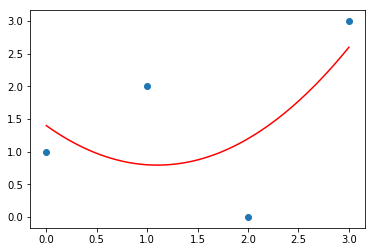

In [218]:
import numpy as np
import matplotlib.pyplot as plt

def estimate(weights, x, order):
    est = 0
    for i in range(order+1):
        est += weights[i] * x ** i
    return est

def cost_function(x, y, weights, m):
    cost = 0
    for i in range(m-1):
        cost += ((y - (weights[i] * x ** i)) ** 2)
    return ((1/(2*m)) * np.sum(cost ** 2))


from IPython.display import clear_output
def live_plot(weights):  
    clear_output(wait = True)
    plt.scatter(x,y)
    u = np.linspace(0,3,100)
    plt.plot(u, (u ** 2) * weights[2] + u * weights[1] + weights[0], 'r-')
    plt.show()

def descent(A, b, iterations, descent_rate, order):
    x = A.T[0]
    y = b.reshape(4)

    # features
    ones = np.vstack(np.ones(len(A)))
    x = np.vstack(A.T[0])
    x2 = np.vstack(A.T[0] ** 2)

    # Our feature matrix
    features = np.concatenate((ones,x,x2), axis = 1).T
    # Initialize our coefficients to zero
    weights = np.zeros(order + 1)
    m = len(y)

    # gradient descent

    for i in range(iterations):
        est = estimate(weights, x, order).T
        difference = est - y
        weights = weights + (-descent_rate * (1/m) * np.matmul(difference, features.T)[0])
        cost = cost_function(x, y, weights, m)
        # this plots the curve every 100 iterations, as it converges towards a good fit
        if(i % 100 == 0):
            live_plot(weights)
            pass
          
    live_plot(weights)
    
A = np.array(((0,1),
             (1,1),
             (2,1),
             (3,1)))

b = np.array((1,2,0,3), ndmin = 2 ).T

# These parameters didn't matter too much for fiiting a quadratic function, but in the next block where
# we're plotting a cubic function, configuring number of iterations and the rate of descent made a big
# impact on the shape of our curve and the time it took to finally converge
iterations = 4000
descent_rate = 0.05
order = 2
descent(A, b, iterations, descent_rate, order)

#### Experimenting with number of iterations and step size for gradient descent:
For a polynomial of a higher degree, manually adjusting these values, I found that they really did affect the shape of our curve. The numbers below are the best configuration that I found, to a get a good fit. If we set the step size any higher we overshoot, if we set it lower, it takes a lot more iterations to converge. If we reduce the iterations we don't get a good fit, if we increase it more, there will be no additional benefit because it converges at some point. Hit run while looking at the cell output below, and it should show the curve gradually converging:

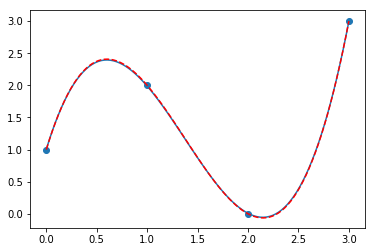

In [186]:
import numpy as np
import matplotlib.pyplot as plt

def estimate(weights, x, order):
    est = 0
    for i in range(order+1):
        est += weights[i] * x ** i
    return est

def cost_function(x, y, weights, m):
    cost = 0
    for i in range(m-1):
        cost += ((y - (weights[i] * x ** i)) ** 2)
    return ((1/(2*m)) * np.sum(cost ** 2))


from IPython.display import clear_output
def live_plot(weights, p3):  
    clear_output(wait = True)
    plt.scatter(x,y)
    u = np.linspace(0,3,100)
    plt.plot(u, (u ** 3) * weights[3] + (u ** 2) * weights[2] + u * weights[1] + weights[0], '-')
    plt.plot(u, np.polyval(p3,u), 'r--')
    plt.show()

def descent(A, b, iterations, descent_rate, order):
    x = A.T[0]
    y = b.reshape(4)

    # features
    ones = np.vstack(np.ones(len(A)))
    x = np.vstack(A.T[0])
    x2 = np.vstack(A.T[0] ** 2)
    x3 = np.vstack(A.T[0] ** 3)

    # Our feature matrix
    features = np.concatenate((ones,x,x2,x3), axis = 1).T
    # Initialize our coefficients to zero
    weights = np.zeros(order + 1)
    m = len(y)

    # numpy fit for reference
    p3 = np.polyfit(A.T[0],b,3)
    # gradient descent
    for i in range(iterations):
        est = estimate(weights, x, order).T
        difference = est - y
        weights = weights + (-descent_rate * (1/m) * np.matmul(difference, features.T)[0])
        cost = cost_function(x, y, weights, m)
        # this plots the curve every 100 iterations, as it converges towards a good fit
        if(i % 100 == 0):
            live_plot(weights, p3)
            pass
        
    live_plot(weights, p3)
    
A = np.array(((0,1),
             (1,1),
             (2,1),
             (3,1)))

b = np.array((1,2,0,3), ndmin = 2 ).T

iterations = 60000
descent_rate = 0.008
order = 3
descent(A, b, iterations, descent_rate, order)


### 3. Print the error for both models. Which model performs better?
As expected, the quadratic fit has a lower error. The curve is trying harder to be as close as possible to the data points. Below are the errors for both functions (they can also be seen in their respective cells above, underneath their graphs):

- __Linear Fit Error: 1.049__

- __Quadratic Fit Error: 0.8__

Hence obviously, the quadratic fit has a smaller error than the linear fit.

### 4. Add a cubic term. How does the error improve?
From the shape of the curve, I can already tell that the error is very small. Code:

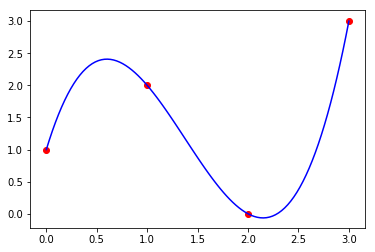

Mean squared error: 2.344908762292088e-26
Rounded Mean Squared Error: 0.0


In [91]:
import numpy as np
import matplotlib.pyplot as plt

A = np.array(((0,1),
             (1,1),
             (2,1),
             (3,1)))
xfeature = A.T[0]
squaredfeature = A.T[0] ** 2
cubedfeature = A.T[0] ** 3
ones = np.ones(4)

b = np.array((1,2,0,3), ndmin=2 ).T
b = b.reshape(4)

order = 3

features = np.concatenate((np.vstack(ones), np.vstack(xfeature), np.vstack(squaredfeature), np.vstack(cubedfeature)), axis = 1)
xstar = np.matmul( np.matmul( np.linalg.inv( np.matmul(features.T, features) ), features.T), b)

plt.scatter(A.T[0],b, c = 'red')
u = np.linspace(0,3,100)
plt.plot(u, u**3*xstar[3] + u**2*xstar[2] + u*xstar[1] + xstar[0], 'b-')
plt.show()

error = []

for i in range(len(b)):
    y_pred = (A.T[0][i] ** 3) * xstar[3] + (A.T[0][i] ** 2) * xstar[2] + A.T[0][i]*xstar[1] + xstar[0]
    error.append(np.square(y_pred - b[i]))

print("Mean squared error:", np.sum(error)/len(b))
print("Rounded Mean Squared Error:", round(np.sum(error)/len(b)))

The error is very small, and is technically negligible. Adding a cubic term to our function gave us a perfect fit for our data points.

### 5. Add a quartic term. What happened? Why?

Well the analytical solution did not work out well for me.

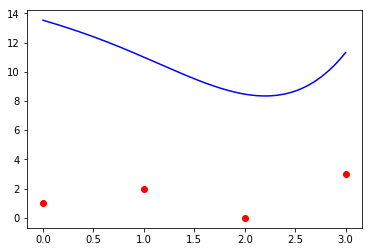

Mean squared error: 536.2012157858026
Rounded Mean Squared Error: 536.0


In [110]:
## import numpy as np
import matplotlib.pyplot as plt

A = np.array(((0,1),
             (1,1),
             (2,1),
             (3,1)))
xfeature = A.T[0]
squaredfeature = A.T[0] ** 2
cubedfeature = A.T[0] ** 3
quart = A.T[0] ** 4
ones = np.ones(4)

b = np.array((1,2,0,3), ndmin=2 ).T
b = b.reshape(4)

order = 3

features = np.concatenate((np.vstack(ones), np.vstack(xfeature), np.vstack(squaredfeature), np.vstack(cubedfeature), np.vstack(quart)), axis = 1)
xstar = np.matmul( np.matmul( np.linalg.inv( np.matmul(features.T, features) ), features.T), b)

plt.scatter(A.T[0],b, c = 'red')
u = np.linspace(0,3,10000)
plt.plot(u, (u ** 4) * xstar[4] + (u ** 3) * xstar[3] + (u ** 2) * xstar[2] + u * xstar[1] + xstar[0], 'b-')
plt.show()

for i in range(len(b)):
    y_pred = (A.T[0][i] ** 4) * xstar[4] + (A.T[0][i] ** 3) * xstar[3] + (A.T[0][i] ** 2) * xstar[2] + A.T[0][i]*xstar[1] + xstar[0]
    error.append(np.square(y_pred - b[i]))

print("Mean squared error:", np.sum(error)/len(b))
print("Rounded Mean Squared Error:", round(np.sum(error)/len(b)))


Honestly, I don't know what is going on here, it's not fitting the data well. One possible explanation could be that we have less points that our degree + 1 and it is not able to find a good fit for the data. The gradient descent code I wrote is actually fitting it though:

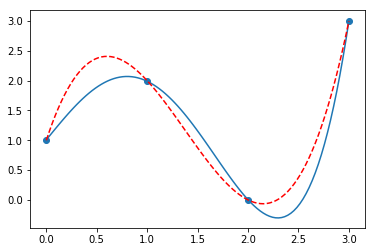

In [108]:
# import numpy as np
import matplotlib.pyplot as plt

def estimate(weights, x, order):
    est = 0
    for i in range(order+1):
        est += weights[i] * x ** i
    return est

def cost_function(x, y, weights, m):
    cost = 0
    for i in range(m-1):
        cost += ((y - (weights[i] * x ** i)) ** 2)
    return ((1/(2*m)) * np.sum(cost ** 2))


from IPython.display import clear_output
def live_plot(x,y,weights, p3):  
    clear_output(wait = True)
    plt.scatter(x,y)
    u = np.linspace(0,3,100)
    plt.plot(u, (u ** 4) * weights[4] + (u ** 3) * weights[3] + (u ** 2) * weights[2] + u * weights[1] + weights[0], '-')
    plt.plot(u, np.polyval(p3,u), 'r--')
    plt.show()

def descent(A, b, iterations, descent_rate, order):
    x = A.T[0]
    y = b.reshape(4)

    # features
    ones = np.vstack(np.ones(len(A)))
    x = np.vstack(A.T[0])
    x2 = np.vstack(A.T[0] ** 2)
    x3 = np.vstack(A.T[0] ** 3)
    x4 = np.vstack(A.T[0] ** 4)

    # Our feature matrix
    features = np.concatenate((ones,x,x2,x3,x4), axis = 1).T
    # Initialize our coefficients to zero
    weights = np.zeros(order + 1)
    m = len(y)

    # numpy fit for reference
    p3 = np.polyfit(A.T[0],b,3)
    # gradient descent
    for i in range(iterations):
        est = estimate(weights, x, order).T
        difference = est - y
        weights = weights + (-descent_rate * (1/m) * np.matmul(difference, features.T)[0])
        cost = cost_function(x, y, weights, m)
        # this plots the curve every 100 iterations, as it converges towards a good fit
        if(i % 1000 == 0):
            live_plot(x,y,weights, p3)
            pass
        
    live_plot(x,y,weights, p3)
    
A = np.array(((0,1),
             (1,1),
             (2,1),
             (3,1)))

b = np.array((1,2,0,3), ndmin = 2 ).T

iterations = 100000
descent_rate = 0.001
order = 4
descent(A, b, iterations, descent_rate, order)


We can see that, compared to the cubic function, we are still getting a perfect fit that is maybe a little more skewed and angular than the cubic fit. I would assume the error is still very low and negligible after observing this graph.